Importation des library

In [7]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
plt.style.use('dark_background')

Chargement des données

In [8]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
#day
time = "15m"
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2024-09-01', 
    interval=time
)

0it [00:00, ?it/s]

Mise en forme des données

In [9]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.index = df_raw.index.tz_convert('Europe/Paris')
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-09 19:30:00+01:00,3375.26,3383.01,3386.77,3374.85,3033.6222
2025-12-09 19:45:00+01:00,3376.06,3375.27,3378.61,3360.22,5586.5180
2025-12-09 20:00:00+01:00,3366.66,3376.07,3378.34,3362.00,3991.5322
2025-12-09 20:15:00+01:00,3371.07,3366.66,3375.58,3364.70,3484.4142
2025-12-09 20:30:00+01:00,3369.71,3371.08,3377.27,3366.28,2426.2899


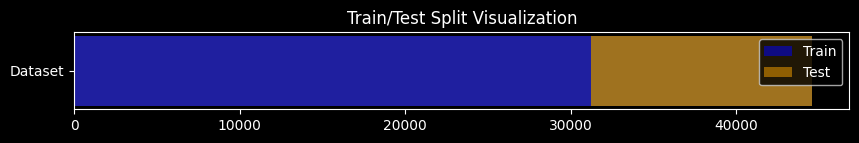

In [10]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [11]:
# Selection du train_set comme données d'entrainement
df = train_data.copy()

In [12]:
for body_threshold in np.arange(0.0001, 0.01, 0.0001):
    df_test = df.copy()  # <-- copie fraîche à chaque tour

    df_test['body'] = (df_test['Close'] - df_test['Open']).abs() / df_test['Open']
    df_test['imbalance_up'] = (df_test['body'] > body_threshold) & (df_test['Close'] > df_test['Open'])
    df_test['imbalance_down'] = (df_test['body'] > body_threshold) & (df_test['Close'] < df_test['Open'])
    df_test['imbalance_high'] = np.where(df_test['imbalance_up'], df_test['High'], np.nan)
    df_test['imbalance_low'] = np.where(df_test['imbalance_down'], df_test['Low'], np.nan)
    df_test['last_imbalance_high'] = df_test['imbalance_high'].ffill()
    df_test['last_imbalance_low'] = df_test['imbalance_low'].ffill()
    df_test['long_signal'] = (df_test['last_imbalance_high'].notna()) & (df_test['Low'] <= df_test['last_imbalance_high']) & (df_test['imbalance_up'].shift(1).notna())
    df_test['short_signal'] = (df_test['last_imbalance_low'].notna()) & (df_test['High'] >= df_test['last_imbalance_low']) & (df_test['imbalance_down'].shift(1).notna())

    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=df_test['long_signal'],
        exits=df_test['short_signal'],
        init_cash=10000,
        fees=0.001,
        slippage=0.001,
        size_type='percent',
        size=0.05,
        freq='15m'
    )

    stats = portfolio.stats()
    stats['body_threshold'] = body_threshold
    stats = stats.to_frame().T
    stats.to_csv('backtest_4.csv', mode='a', header=not os.path.exists('backtest_4.csv'), index=False)
    print(f"Backtest completed for body_threshold: {body_threshold}")

Backtest completed for body_threshold: 0.0001
Backtest completed for body_threshold: 0.0002
Backtest completed for body_threshold: 0.00030000000000000003
Backtest completed for body_threshold: 0.0004
Backtest completed for body_threshold: 0.0005
Backtest completed for body_threshold: 0.0006000000000000001
Backtest completed for body_threshold: 0.0007000000000000001
Backtest completed for body_threshold: 0.0008
Backtest completed for body_threshold: 0.0009000000000000001
Backtest completed for body_threshold: 0.001
Backtest completed for body_threshold: 0.0011
Backtest completed for body_threshold: 0.0012000000000000001
Backtest completed for body_threshold: 0.0013000000000000002
Backtest completed for body_threshold: 0.0014000000000000002
Backtest completed for body_threshold: 0.0015
Backtest completed for body_threshold: 0.0016
Backtest completed for body_threshold: 0.0017000000000000001
Backtest completed for body_threshold: 0.0018000000000000002
Backtest completed for body_threshold